In [89]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

datta = pd.read_csv("rates.csv")

del datta["Unnamed: 0"]
datta

,t,x,Y
0,0.000000,0.1,0.013105
1,0.000000,0.2,0.020978
2,0.000000,0.3,0.026742
3,0.000000,0.4,0.031033
4,0.000000,0.5,0.034280
...,...,...,...
3595,2.916667,9.6,0.047593
3596,2.916667,9.7,0.047625
3597,2.916667,9.8,0.047656
3598,2.916667,9.9,0.047687


DATA IMPORTING + PRREPARING

In [90]:
maturities = datta['x'].unique()
x0 = 0.1
dt = 1/12
rshort = datta[datta['x'] == x0]['Y'].values
rshort

array([0.01310501, 0.00598074, 0.00625412, 0.00226763, 0.00173253,
       0.00178329, 0.00163088, 0.00138393, 0.00054268, 0.00066994,
       0.00083191, 0.00059846, 0.00125889, 0.00155575, 0.00148975,
       0.00176957, 0.0013986 , 0.00181467, 0.00190381, 0.00184148,
       0.00180951, 0.00205531, 0.00169784, 0.00165244, 0.00142845,
       0.00131224, 0.00081241, 0.00064519, 0.00082789, 0.00079277,
       0.00055816, 0.00049079, 0.00045181, 0.00084547, 0.00088704,
       0.00109511])

In [91]:
data = datta.copy()
# Adding P(t, T)
data['P'] = np.exp(-data['x'] * data['Y'])

# Adding rt
data['r'] = np.repeat(rshort, len(maturities))

# Adding f(t, T)
data['f'] = np.where(data['x'] == x0, data['r'], -(np.log(data["P"]/data["P"].shift()) ) )

data

,t,x,Y,P,r,f
0,0.000000,0.1,0.013105,0.998690,0.013105,0.013105
1,0.000000,0.2,0.020978,0.995813,0.013105,0.002885
2,0.000000,0.3,0.026742,0.992009,0.013105,0.003827
3,0.000000,0.4,0.031033,0.987664,0.013105,0.004390
4,0.000000,0.5,0.034280,0.983006,0.013105,0.004727
...,...,...,...,...,...,...
3595,2.916667,9.6,0.047593,0.633245,0.001095,0.005067
3596,2.916667,9.7,0.047625,0.630045,0.001095,0.005067
3597,2.916667,9.8,0.047656,0.626861,0.001095,0.005067
3598,2.916667,9.9,0.047687,0.623692,0.001095,0.005067


La prime de risk

In [92]:
# Calcul des paramètres BS
BSparams = data.groupby('x').agg(
    volatility=('P', lambda x: np.sqrt((1 / dt) * np.var(np.log(x / x.shift()), ddof=0))),
    return_=('P', lambda x: np.mean(np.log(x / x.shift())) / dt +
                    np.var(np.log(x / x.shift()), ddof=0) / (2 * dt))
).reset_index()

# Calcul de sigma et mu
sigma = np.sqrt(np.mean(BSparams['volatility']**2))
mu = np.mean(BSparams['return_'])

# Calcul de qt et ajout à la DataFrame rates
data['qt'] = (mu - data['r']) / sigma
data

,t,x,Y,P,r,f,qt
0,0.000000,0.1,0.013105,0.998690,0.013105,0.013105,-0.007185
1,0.000000,0.2,0.020978,0.995813,0.013105,0.002885,-0.007185
2,0.000000,0.3,0.026742,0.992009,0.013105,0.003827,-0.007185
3,0.000000,0.4,0.031033,0.987664,0.013105,0.004390,-0.007185
4,0.000000,0.5,0.034280,0.983006,0.013105,0.004727,-0.007185
...,...,...,...,...,...,...,...
3595,2.916667,9.6,0.047593,0.633245,0.001095,0.005067,0.139680
3596,2.916667,9.7,0.047625,0.630045,0.001095,0.005067,0.139680
3597,2.916667,9.8,0.047656,0.626861,0.001095,0.005067,0.139680
3598,2.916667,9.9,0.047687,0.623692,0.001095,0.005067,0.139680


# Chapitre 2 : Modèles Benchmark 

## 1. Modele Nelson-Seigle

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize


# Calibration de Nelson-Siegel
def nelson_siegel_calibration(Y, x):
    def objective_function(coef, Y, x):
        beta0, beta1, beta2, tau = coef
        NS_rates = beta0 + beta1 * (1 - np.exp(-x/tau))/(x/tau) + beta2 * ((1 - np.exp(-x/tau))/(x/tau) - np.exp(-x/tau))
        return np.sum((Y - NS_rates)**2)

    initial_guess = [0.02, -0.01, -0.02, 1.0]
    result = minimize(objective_function, initial_guess, args=(Y, x), method='L-BFGS-B')
    
    if result.success:
        return result.x
    else:
        raise RuntimeError("Calibration failed")

# Fonction pour générer les taux à partir des paramètres calibrés
def nelson_siegel_rates(coef, t):
    beta0, beta1, beta2, tau = coef
    return beta0 + beta1 * (1 - np.exp(-t/tau))/(t/tau) + beta2 * ((1 - np.exp(-t/tau))/(t/tau) - np.exp(-t/tau))


In [94]:
# Supposons que vous avez un DataFrame 'rates' avec les colonnes 'Y' et 'x'
Y_values = data['Y'].values
x_values = data['x'].values

# Calibration de Nelson-Siegel
NS_parameters = nelson_siegel_calibration(Y_values, x_values)
print(NS_parameters)

[ 0.05031919 -0.04987675 -0.03785993  0.57193291]


[0.00161124 0.00296844 0.00445314 0.00601722 0.0076229  0.00924087
 0.01084865 0.01242925 0.01397013 0.01546228 0.01689952 0.01827789
 0.01959517 0.0208505  0.02204406 0.02317682 0.02425031 0.02526652
 0.02622768 0.02713624 0.02799473 0.02880574 0.02957185 0.0302956
 0.03097947 0.03162583 0.03223699 0.03281512 0.03336229 0.03388047
 0.03437148 0.03483707 0.03527885 0.03569835 0.03609699 0.03647609
 0.03683689 0.03718053 0.03750809 0.03782057 0.03811888 0.03840391
 0.03867644 0.03893722 0.03918695 0.03942628 0.0396558  0.03987608
 0.04008763 0.04029094 0.04048647 0.04067464 0.04085584 0.04103043
 0.04119878 0.04136119 0.04151796 0.04166939 0.04181573 0.04195723
 0.04209412 0.04222663 0.04235495 0.04247928 0.0425998  0.04271668
 0.04283009 0.04294017 0.04304706 0.04315091 0.04325184 0.04334997
 0.04344542 0.04353829 0.04362868 0.0437167  0.04380244 0.04388598
 0.0439674  0.04404679 0.04412422 0.04419977 0.04427349 0.04434546
 0.04441574 0.04448438 0.04455145 0.04461699 0.04468105 0.04474

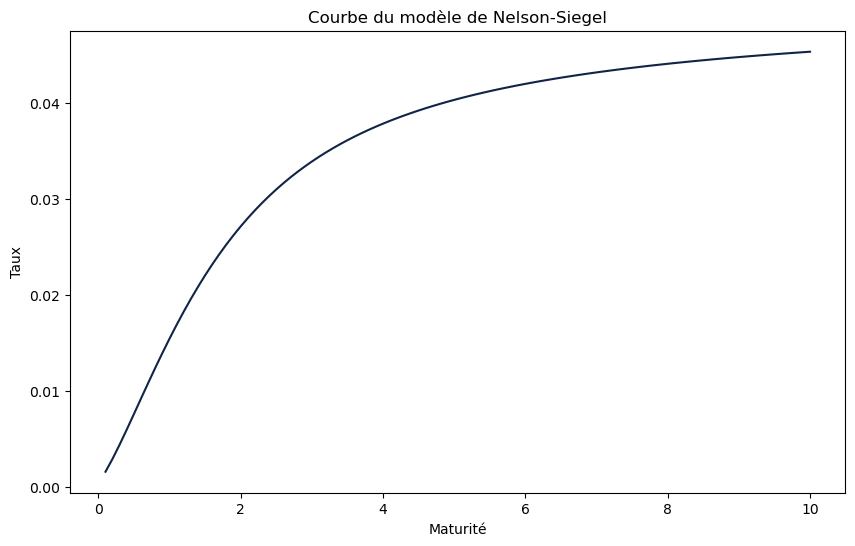

In [95]:
# Génération des taux à partir des paramètres calibrés
maturities = np.linspace(0.1, 10, 100)
curve_NS = nelson_siegel_rates(NS_parameters, maturities)

print(curve_NS)

# Visualisation de la courbe
plt.figure(figsize=(10, 6))
sns.lineplot(x=maturities, y=curve_NS, color='#112446')  # Correction ici
plt.xlabel('Maturité')
plt.ylabel('Taux')
plt.title('Courbe du modèle de Nelson-Siegel')
plt.savefig('courbe.pdf', format='pdf')
plt.show()

# 2. Modele Svensson

In [96]:
# Calibration de Svensson
def svensson_calibration(Y, t):
    def objective_function(coef, Y, t):
        beta0, beta1, beta2, beta3, tau1, tau2 = coef
        S_rates = beta0 + beta1 * (1 - np.exp(-t/tau1))/(t/tau1) + beta2 * ((1 - np.exp(-t/tau1))/(t/tau1) - np.exp(-t/tau1)) + beta3 * ((1 - np.exp(-t/tau2))/(t/tau2) - np.exp(-t/tau2))
        return np.sum((Y - S_rates)**2)

    initial_guess = [0.02, -0.01, -0.02, -0.01, 1.0, 5.0]
    result = minimize(objective_function, initial_guess, args=(Y, t), method='L-BFGS-B')
    
    if result.success:
        return result.x
    else:
        raise RuntimeError("Calibration failed")

# Fonction pour générer les taux à partir des paramètres calibrés
def svensson_rates(coef, t):
    beta0, beta1, beta2, beta3, tau1, tau2 = coef
    return beta0 + beta1 * (1 - np.exp(-t/tau1))/(t/tau1) + beta2 * ((1 - np.exp(-t/tau1))/(t/tau1) - np.exp(-t/tau1)) + beta3 * ((1 - np.exp(-t/tau2))/(t/tau2) - np.exp(-t/tau2))

In [97]:
Y_values = data['Y'].values
x_values = data['x'].values

# Calibration du modèle Svensson
SParameters = svensson_calibration(Y_values, x_values)

print(SParameters)

[ 4.01529456e-02 -4.29901762e-02  2.22520737e-03  3.08302362e-02
  9.97935601e-01  4.99913941e+00]


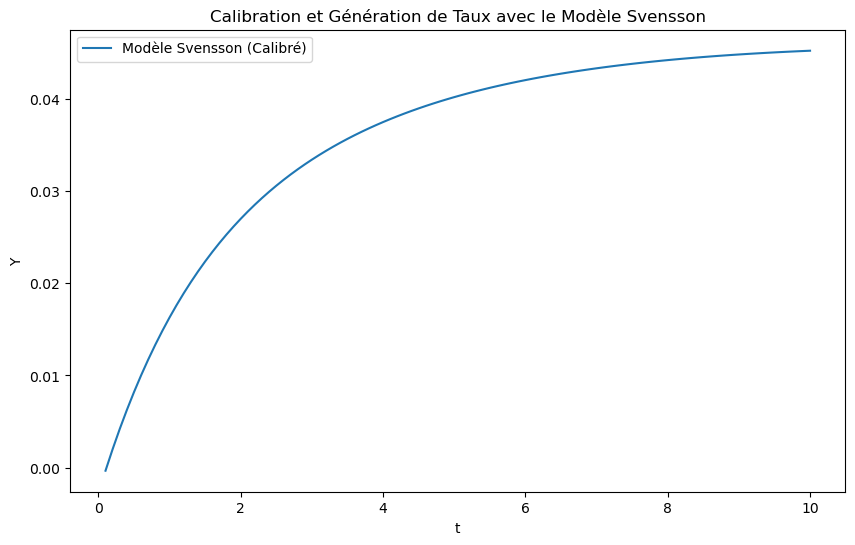

In [98]:
# Génération des taux à partir des paramètres calibrés
maturities = np.linspace(0.1, 10, 100)
svensson_generated_rates = svensson_rates(SParameters, maturities)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(maturities, svensson_generated_rates, label='Modèle Svensson (Calibré)')
plt.title('Calibration et Génération de Taux avec le Modèle Svensson')
plt.xlabel('t')
plt.ylabel('Y')
plt.legend()
plt.savefig('courbem.pdf', format='pdf')
plt.show()


## Comparaison des modeles

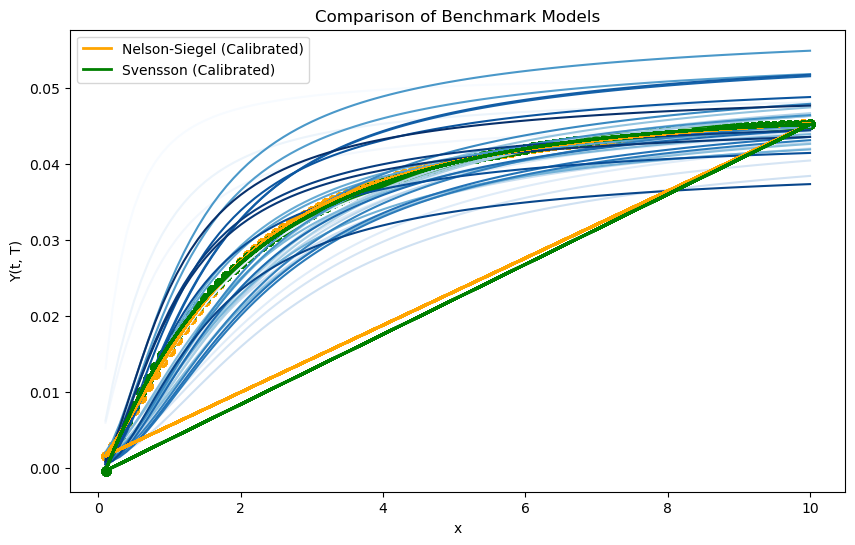

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'rates' is a DataFrame with columns 'x', 'Y', 't'
# 'NSParameters' and 'SParameters' are the calibrated parameters for Nelson-Siegel and Svensson models

# Visualizing Y(t, T) over x
plt.figure(figsize=(10, 6))
sns.lineplot(x='x', y='Y', hue='t', data=data, palette='Blues', legend=False)
plt.plot(data['x'], nelson_siegel_rates(NS_parameters, data['x']), label='Nelson-Siegel (Calibrated)', color='orange', linewidth=2)
plt.plot(data['x'], svensson_rates(SParameters, data['x']), label='Svensson (Calibrated)', color='green', linewidth=2)
plt.scatter(data['x'], nelson_siegel_rates(NS_parameters, data['x']), color='orange', s=40)
plt.scatter(data['x'], svensson_rates(SParameters, data['x']), color='green', s=40)
plt.title('Comparison of Benchmark Models')
plt.xlabel('x')
plt.ylabel('Y(t, T)')
plt.legend()
plt.savefig('compariason_courbe.pdf', format='pdf')
plt.show()

 # chapitre 3 : Modèle À Trois Facteurs 

### 1. Calibration

In [100]:
delta = 0.1 
N = len(maturities) 
time = data['t'].values 
# f0 = data[data['t'] == 0]['f'].values 

# Initial params 
params_init = [ 0.04157374, 0.01830442, 0.0926567, 0.09287434, 0.01661409, 0.0436558 ] 

In [101]:
# Assuming 'data', 'x0', and 'delta' are already defined
Lboundry = data[data['x'] == x0]['f'].values
Uboundry = data[data['x'] == 10]['f'].values


def Fonc(t, r, q, params):
    N = len(r)
    lambda0, lambda1, lambda2, kappa0, kappa1, kappa2 = tuple(params)
    
    def sigma0(t, s, x):
        return lambda0 * np.exp(-kappa0 * (t + x - s))

    def mu0(t, s, x):
        term1 = np.exp(-kappa0 * (t + x - s))
        term2 = np.exp(kappa0 * s) - np.exp(-kappa0 * (t + x - 2 * s))
        return lambda0**2 * term1 * (term2 / kappa0)

    def sigma1(t, s, x):
        return lambda1 * np.exp(-kappa1 * (t + x - s))

    def mu1(t, s, x):
        term1 = np.exp(-kappa1 * (t + x - s))
        term2 = np.exp(kappa1 * s) - np.exp(-kappa1 * (t + x - 2 * s))
        return lambda1**2 * term1 * (term2 / kappa1)

    def sigma2(t, s, x):
        return lambda2 * np.exp(-kappa2 * (t + x - s))

    def mu2(t, s, x):
        term1 = np.exp(-kappa2 * (t + x - s))
        term2 = np.exp(kappa2 * s) - np.exp(-kappa2 * (t + x - 2 * s))
        return lambda2**2 * term1 * (term2 / kappa2)

    def f(t, l, c, r, dW, delta):
        term1 = c + ((r - l) / (2 * delta) + mu0(t, t, c) * c**2 + mu1(t, t, c) * ((r - l) / (2 * delta))**2 + mu2(t, t, c) * ((r - 2 * c + l) / delta**2)**2) * dt
        term2 = sigma0(t, t, c) * c * dW[0] + sigma1(t, t, c) * ((r - l) / (2 * delta)) * dW[1] + sigma2(t, t, c) * ((r - 2 * c + l) / delta**2) * dW[2]
        result = term1 + term2
        return result

    rnext = r.copy()
    dW = np.full(3, q * dt) / 3
    for k in range(1, N-1):
        rnext[k] = f(t, r[k-1], r[k], r[k+1], dW,delta)

    rnext[0] = f(t, r[0], r[0], r[1], dW,delta)
    rnext[N-1] = f(t, r[N-2], r[N-1], r[N-1], dW,delta)

    return rnext

In [130]:
def norm2(x):
    return np.sum(x**2)

def mse(params):
    mse_value = 0
    tt = 0
    while tt < 3-dt:
        f = data[(np.abs(data['t'] - tt) < dt/2)]['f'].values
        q = data[(np.abs(data['t'] - tt) < dt/2)]['qt'].values[0]
        prediction = Fonc(tt, f, q, params)
        tt += dt
        f = data[(np.abs(data['t'] - tt) < dt/2)]['f'].values
        mse_value += norm2(f - prediction) * 10000000

    return mse_value / len(time)

In [131]:
mse(params_init)

1.9035639134730862

In [132]:
# Perform optimization with a different method (e.g., L-BFGS-B)
resultat = minimize(mse, params_init, method='L-BFGS-B')

# Retrieve optimized parameters
params_out = resultat.x

# Print the result
mse_value = np.sqrt(resultat.fun)
print("mse =", round(mse_value / 10, 2), "%")

mse = 0.13 %


In [135]:
params_out
# params_out = np.array([-2.01713266e-01, -1.55581697e+01,  1.06989647e-01, -3.95899194e+02,-4.70708576e-01,  1.21654725e+00])

array([-2.01713266e-01, -1.55581697e+01,  1.06989647e-01, -3.95899194e+02,
       -4.70708576e-01,  1.21654725e+00])

### Backtesting 

In [128]:
import pandas as pd
import numpy as np

# Filter data for tt
tt = 12 * dt
data_now = data[abs(data['t'] - tt) < dt/2]
data_next = data[abs(data['t'] - tt - 1) < dt/2]

freal = data_next['f'].values
Yreal = data_next['Y'].values

q = data_now["qt"].values[0]
freallag = data_now['f'].values
Yreallag = data_now['Y'].values

# Calculate estimates using Fonc function
festim = Fonc(tt , r=freallag, q=q, params=params_out)
Yestim = delta * np.cumsum(festim) / maturities

       x     freal     Yreal  Yreallag  freallag    festim    Yestim  \
0    0.1  0.001428  0.001428  0.001259  0.001259  0.001088  0.001088   
1    0.2  0.000166  0.001545  0.001619  0.000198  0.000140  0.000614   
2    0.3  0.000286  0.001982  0.002262  0.000355  0.000401  0.000543   
3    0.4  0.000473  0.002670  0.003123  0.000571  0.000628  0.000564   
4    0.5  0.000708  0.003551  0.004151  0.000826  0.000890  0.000629   
..   ...       ...       ...       ...       ...       ...       ...   
95   9.6  0.005227  0.044942  0.046075  0.005333  0.005299  0.004603   
96   9.7  0.005227  0.045017  0.046150  0.005333  0.005299  0.004610   
97   9.8  0.005227  0.045091  0.046223  0.005333  0.005299  0.004617   
98   9.9  0.005227  0.045164  0.046295  0.005333  0.005299  0.004624   
99  10.0  0.005227  0.045235  0.046366  0.005333  0.005299  0.004631   

    YestimNS   YestimS  
0  -0.000345 -0.000345  
1   0.001993  0.001993  
2   0.004186  0.004186  
3   0.006247  0.006247  
4   0.0081

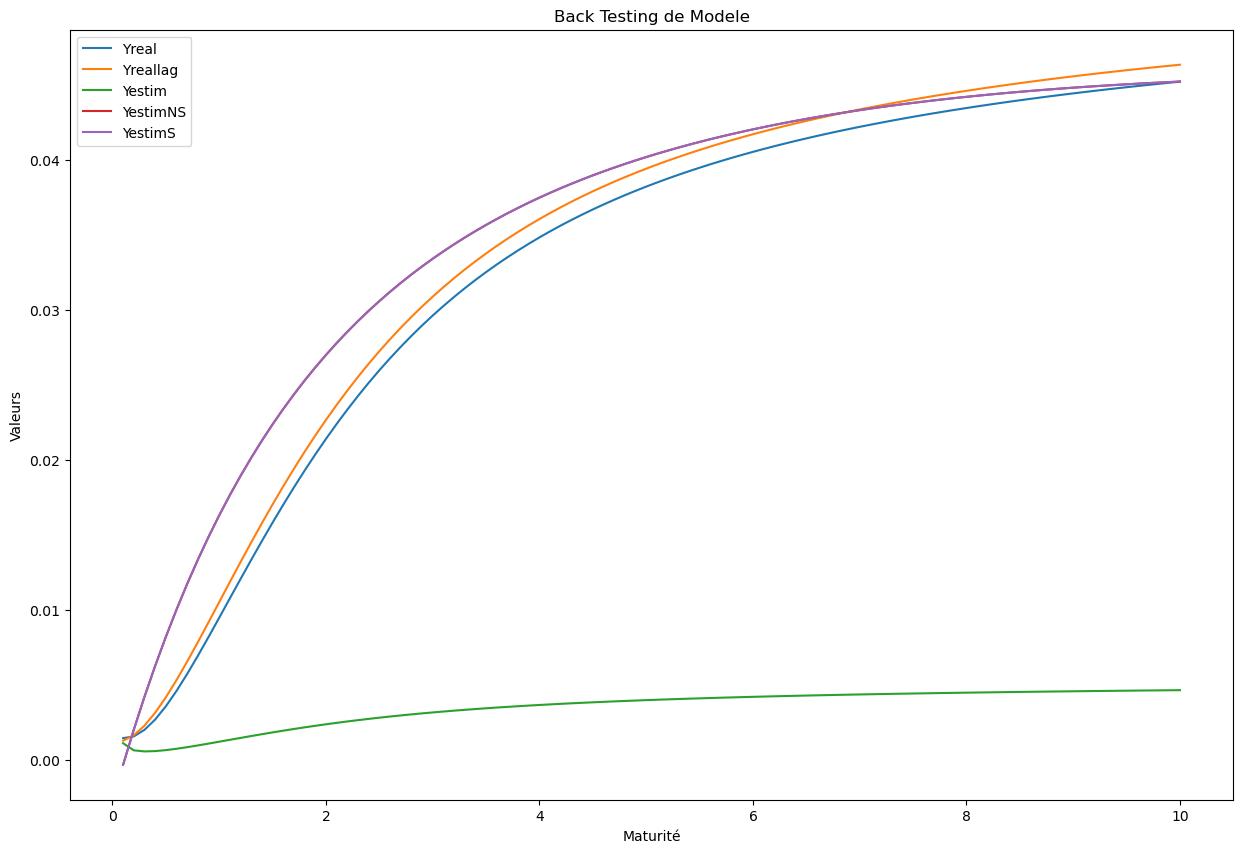

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create a DataFrame
CurveQ = pd.DataFrame({
    'x': maturities,
    'freal': freal,
    'Yreal': Yreal,
    'Yreallag': Yreallag,
    'freallag': freallag,
    'festim': festim,
    'Yestim': Yestim,
    'YestimNS':  svensson_generated_rates,
    'YestimS': svensson_generated_rates
})

# Print or use the DataFrame as needed
print(CurveQ)
# Plot each column
plt.figure(figsize=(15, 10))

for column in CurveQ.columns:
    if column in ["Yreal","Yreallag","Yestim","YestimNS","YestimS"] :
        plt.plot(CurveQ['x'], CurveQ[column], label=column)

plt.xlabel('Maturité')
plt.ylabel('Valeurs')
plt.title('Back Testing de Modele')
plt.legend()
plt.savefig('graphiques.pdf', format='pdf')
plt.show()